# ESG Pre-filter Classifier - Model Selection & Tuning

This notebook performs model selection and hyperparameter tuning for the ESG pre-filter classifier. It loads the feature transformer created in ep1_EDA_FE.ipynb and focuses on finding the optimal model.

## Objective
Select the best classification model and tune hyperparameters to maximize F2 score (recall-weighted).

**Important:** This notebook uses ONLY training and validation data. Test set evaluation, threshold optimization, and deployment are performed in ep3_model_evaluation_deployment.ipynb.

## Contents
1. [Setup](#setup)
2. [Data Loading & Split](#1-data-loading--split)
3. [Feature Transformation](#2-feature-transformation)
4. [Baseline Model Comparison](#3-baseline-model-comparison)
5. [Hyperparameter Tuning](#4-hyperparameter-tuning)
6. [Overfitting Analysis](#5-overfitting-analysis)
7. [Final Model Selection](#6-final-model-selection)

## Setup

In [1]:
# Standard imports
import json
import sys
import warnings
from pathlib import Path

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.sparse as sp
import seaborn as sns

# Sklearn imports
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.svm import LinearSVC

# Add project root to path
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

# Project imports
from src.ep1_nb.data_utils import load_jsonl_data, split_train_val_test
from src.ep1_nb.preprocessing import clean_text, create_text_features
from src.ep1_nb.feature_transformer import EPFeatureTransformer
from src.ep1_nb.modeling import (
    create_search_object,
    tune_with_logging,
    get_best_params_summary,
    get_best_model,
    compare_models,
    evaluate_model,
)
from src.ep2_nb.overfitting_analysis import (
    analyze_cv_train_val_gap,
    analyze_iteration_performance,
    display_top_hyperparameter_runs,
    get_gap_summary,
    get_top_hyperparameter_runs,
)

# Settings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', message='.*sklearn.utils.parallel.delayed.*')
pd.set_option('display.max_columns', 50)
plt.style.use('seaborn-v0_8-whitegrid')

# Configuration
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
TARGET_COL = 'has_esg'
N_FOLDS = 3

# Paths
DATA_PATH = project_root / 'data' / 'ep_training_data.jsonl'
MODELS_DIR = project_root / 'models'
IMAGES_DIR = project_root / 'images'

print("Setup complete!")

Setup complete!


## 1. Data Loading & Split

Load data and apply identical preprocessing and split as ep1 to ensure consistency.

In [2]:
# Load the ESG pre-filter training data (same as ep1)
df = load_jsonl_data(DATA_PATH)

# Create combined text features (identical to ep1)
df['text_features'] = create_text_features(
    df,
    text_col='content',
    title_col='title',
    brands_col='brands',
    source_name_col=None,
    category_col=None,
    include_metadata=False,
    clean_func=clean_text
)

print(f"\nText features created!")
print(f"Sample:\n{df['text_features'].iloc[0][:300]}...")

Loaded 902 records from ep_training_data.jsonl
Columns: ['article_id', 'title', 'content', 'brands', 'source_name', 'category', 'has_esg', 'source', 'skip_reason']
Memory usage: 6.30 MB

Text features created!
Sample:
the factors behind lululemon ceo calvin mcdonald departure from the brand the factors behind lululemon ceo calvin mcdonald departure from the brand lululemon after seven years as ceo of athleisure giant lululemon retail veteran calvin mcdonald announced he would be leaving the company this move will...


In [3]:
# Split with stratification (identical to ep1 - same random_state ensures identical splits)
train_df, val_df, _ = split_train_val_test(
    df,
    target_col=TARGET_COL,
    train_ratio=0.6,
    val_ratio=0.2,
    test_ratio=0.2,
    random_state=RANDOM_STATE
)

TRAIN/VALIDATION/TEST SPLIT

Total samples: 902

Split ratios: 60% / 20% / 20%

Resulting sizes:
  Train:      540 (59.9%)
  Validation: 181 (20.1%)
  Test:       181 (20.1%)

Class distribution (stratified by 'has_esg'):
  Train: 1: 73.5%, 0: 26.5%
  Val: 1: 73.5%, 0: 26.5%
  Test: 1: 73.5%, 0: 26.5%


## 2. Feature Transformation

Load the fitted feature transformer from ep1 and transform all splits.

In [4]:
# Load the fitted feature transformer from ep1
transformer_path = MODELS_DIR / 'ep_feature_transformer.joblib'
transformer = joblib.load(transformer_path)

# Load the transformer config
config_path = MODELS_DIR / 'ep_feature_config.json'
with open(config_path) as f:
    transformer_config = json.load(f)

print(f"Loaded transformer: {transformer}")
print(f"\nTransformer config:")
for key, value in transformer_config.items():
    print(f"  {key}: {value}")

Loaded transformer: EPFeatureTransformer(method='tfidf_lsa', max_features=10000, fitted=True)

Transformer config:
  method: tfidf_lsa
  max_features: 10000
  ngram_range: [1, 2]
  min_df: 2
  max_df: 0.95
  sublinear_tf: True
  norm: l2
  char_ngram_range: [3, 5]
  char_max_features: 5000
  lsa_n_components: 70
  context_window_words: 20
  doc2vec_vector_size: 100
  doc2vec_min_count: 2
  doc2vec_epochs: 40
  doc2vec_dm: 1
  doc2vec_window: 4
  sentence_model_name: all-MiniLM-L6-v2
  include_vocab_features: True
  vocab_window_size: 15
  proximity_window_size: 15
  include_metadata_in_text: True
  include_metadata_features: False
  random_state: 42


In [5]:
# Transform train and validation splits using the fitted transformer
# NOTE: Test data is NOT used in this notebook - final evaluation is done in ep3
X_train = transformer.transform(train_df['text_features'])
X_val = transformer.transform(val_df['text_features'])

# Extract targets
y_train = train_df[TARGET_COL].values
y_val = val_df[TARGET_COL].values

# Combine train+val for hyperparameter tuning (CV will create internal train/val splits)
if sp.issparse(X_train):
    X_trainval = sp.vstack([X_train, X_val])
else:
    X_trainval = np.vstack([X_train, X_val])
y_trainval = np.concatenate([y_train, y_val])

print(f"Feature dimensionality: {X_train.shape[1]}")
print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"X_trainval shape: {X_trainval.shape} (for hyperparameter tuning)")
print(f"\nNote: Test data reserved for final evaluation in ep3 notebook")

Feature dimensionality: 70
X_train shape: (540, 70)
X_val shape: (181, 70)
X_trainval shape: (721, 70) (for hyperparameter tuning)

Note: Test data reserved for final evaluation in ep3 notebook


## 3. Baseline Model Comparison

Train and evaluate multiple classifiers on the transformed features to identify the best performing models for hyperparameter tuning.

In [6]:
# Cross-validation strategy
cv = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE)
print(f"Using {N_FOLDS}-fold stratified CV")

# F2 scorer (weights recall 2x higher than precision)
f2_scorer = make_scorer(fbeta_score, beta=2)

Using 3-fold stratified CV


In [7]:
# Define baseline models
baseline_models = {
    'Logistic Regression': LogisticRegression(
        max_iter=2000,
        class_weight=None,
        random_state=RANDOM_STATE,
        solver='lbfgs'
    ),
    'Linear SVM': CalibratedClassifierCV(
        LinearSVC(max_iter=2000, random_state=RANDOM_STATE, class_weight=None),
        cv=3
    ),
    'Random Forest': RandomForestClassifier(
        n_estimators=100,
        random_state=RANDOM_STATE,
        class_weight=None,
        n_jobs=-1
    ),
    'HistGradientBoosting': HistGradientBoostingClassifier(
        max_iter=100,
        max_depth=5,
        class_weight=None,
        random_state=RANDOM_STATE,
    ),
}

In [8]:
# Train and evaluate baseline models
baseline_results = []

# Models that require dense arrays
dense_required_models = {'HistGradientBoosting'}

for name, model in baseline_models.items():
    print(f"\nTraining {name}...")
    
    # Convert to dense if required
    if name in dense_required_models and sp.issparse(X_train):
        X_train_fit = X_train.toarray()
        X_val_fit = X_val.toarray()
    else:
        X_train_fit = X_train
        X_val_fit = X_val
    
    model.fit(X_train_fit, y_train)
    
    # Evaluate on validation set
    metrics = evaluate_model(
        model, X_val_fit, y_val,
        model_name=name,
        dataset_name='Validation',
        verbose=True,
        plot=False
    )
    
    # Add F2 score to metrics
    y_pred = model.predict(X_val_fit)
    metrics['f2'] = fbeta_score(y_val, y_pred, beta=2)
    print(f"  F2 Score:  {metrics['f2']:.4f} (recall-weighted)")
    
    baseline_results.append(metrics)


Training Logistic Regression...

MODEL EVALUATION: Logistic Regression on Validation

Classification Metrics:
  Accuracy:  0.7403
  Precision: 0.7416
  Recall:    0.9925
  F1 Score:  0.8489
  ROC-AUC:   0.8051
  PR-AUC:    0.9234

Confusion Matrix:
  TN: 2  FP: 46
  FN: 1  TP: 132

                precision    recall  f1-score   support

Not Sportswear       0.67      0.04      0.08        48
    Sportswear       0.74      0.99      0.85       133

      accuracy                           0.74       181
     macro avg       0.70      0.52      0.46       181
  weighted avg       0.72      0.74      0.64       181

  F2 Score:  0.9296 (recall-weighted)

Training Linear SVM...

MODEL EVALUATION: Linear SVM on Validation

Classification Metrics:
  Accuracy:  0.7956
  Precision: 0.7963
  Recall:    0.9699
  F1 Score:  0.8746
  ROC-AUC:   0.8383
  PR-AUC:    0.9371

Confusion Matrix:
  TN: 15  FP: 33
  FN: 4  TP: 129

                precision    recall  f1-score   support

Not Sportswear 


Baseline Model Comparison (Validation Set)
                          f2  recall  precision      f1  accuracy  pr_auc
model_name                                                               
Logistic Regression   0.9296  0.9925     0.7416  0.8489    0.7403  0.9234
Linear SVM            0.9294  0.9699     0.7963  0.8746    0.7956  0.9371
Random Forest         0.9344  0.9850     0.7751  0.8675    0.7790  0.9373
HistGradientBoosting  0.8641  0.8797     0.8069  0.8417    0.7569  0.9333

Figure saved to images/ep_baseline_comparison.png


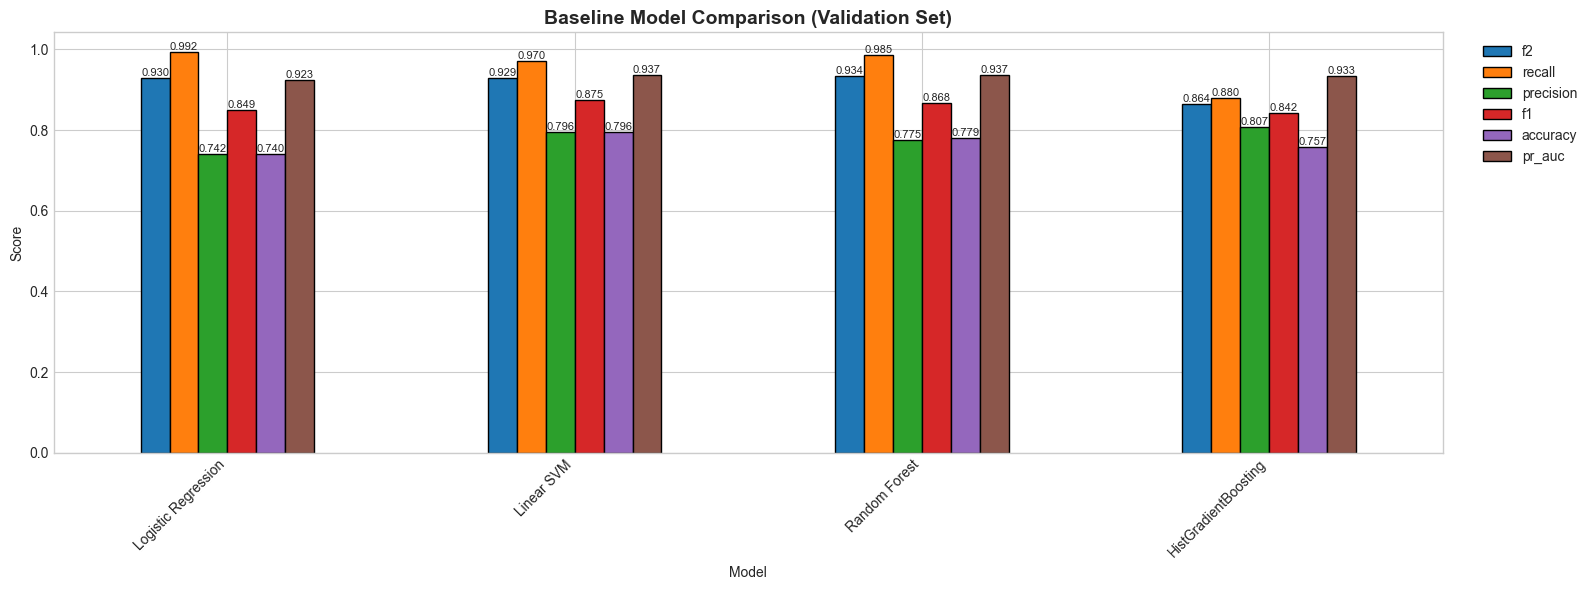

In [9]:
# Compare baseline models (with F2 as primary metric)
baseline_comparison = compare_models(
    baseline_results,
    metrics_to_display=['f2', 'recall', 'precision', 'f1', 'accuracy', 'pr_auc'],
    title='Baseline Model Comparison (Validation Set)',
    save_path='images/ep_baseline_comparison.png'
)

## 4. Hyperparameter Tuning

Tune the top-performing baseline models using cross-validation on train+val combined (80% of data). The test set remains completely held out for final evaluation.

### 4.1 Logistic Regression Tuning

In [24]:
# Logistic Regression parameter grid
lr_param_grid = {
    'C': [0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0],
    'penalty': ['l2'],
    'solver': ['lbfgs'],
    'class_weight': ['balanced', None],
}

lr_search = create_search_object(
    search_type='grid',
    estimator=LogisticRegression(max_iter=2000, random_state=RANDOM_STATE),
    param_grid=lr_param_grid,
    cv=cv,
    refit='f2'
)

lr_search, lr_log, lr_csv = tune_with_logging(
    lr_search, X_trainval, y_trainval,
    model_name='ep_logistic_regression'
)


HYPERPARAMETER TUNING: ep_logistic_regression
Total parameter combinations: 24
Cross-validation folds: 3
Total fits: 72
Log file: models/logs/ep_logistic_regression_20251225_010526.log

Tuning complete!
Best score (f2): 0.9374
Results saved to: models/logs/ep_logistic_regression_20251225_010526_cv_results.csv


### 4.2 Random Forest Tuning

In [11]:
# Random Forest parameter grid
rf_param_grid = {
    'n_estimators': [50, 70, 100, 150, 200],
    'max_depth': [10, 15, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2],
    'class_weight': ['balanced', None],
}

rf_search = create_search_object(
    search_type='grid',
    estimator=RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1),
    param_grid=rf_param_grid,
    cv=cv,
    refit='f2'
)

rf_search, rf_log, rf_csv = tune_with_logging(
    rf_search, X_trainval, y_trainval,
    model_name='ep_random_forest'
)


HYPERPARAMETER TUNING: ep_random_forest
Total parameter combinations: 240
Cross-validation folds: 3
Total fits: 720
Log file: models/logs/ep_random_forest_20251225_005528.log

Tuning complete!
Best score (f2): 0.9276
Results saved to: models/logs/ep_random_forest_20251225_005528_cv_results.csv


### 4.3 HistGradientBoosting Tuning

In [12]:
# HistGradientBoosting parameter grid
hgb_param_grid = {
    'max_iter': [50, 100, 150, 200],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_samples_leaf': [5, 10, 20],
    'l2_regularization': [0.0, 0.1],
    'class_weight': ['balanced', None],
}

hgb_search = create_search_object(
    search_type='grid',
    estimator=HistGradientBoostingClassifier(random_state=RANDOM_STATE),
    param_grid=hgb_param_grid,
    cv=cv,
    refit='f2'
)

# HGB requires dense arrays
X_trainval_hgb = X_trainval.toarray() if sp.issparse(X_trainval) else X_trainval

hgb_search, hgb_log, hgb_csv = tune_with_logging(
    hgb_search, X_trainval_hgb, y_trainval,
    model_name='ep_hist_gradient_boosting'
)


HYPERPARAMETER TUNING: ep_hist_gradient_boosting
Total parameter combinations: 432
Cross-validation folds: 3
Total fits: 1296
Log file: models/logs/ep_hist_gradient_boosting_20251225_005620.log

Tuning complete!
Best score (f2): 0.9102
Results saved to: models/logs/ep_hist_gradient_boosting_20251225_005620_cv_results.csv


### 4.4 Linear SVM Tuning

In [13]:
# Linear SVM parameter grid
# Using CalibratedClassifierCV to get probability estimates from LinearSVC
# Parameters are prefixed with 'estimator__' to access the inner LinearSVC
svm_param_grid = {
    'estimator__C': [0.01, 0.1, 1, 10],
    'estimator__class_weight': ['balanced', None],
}

svm_search = create_search_object(
    search_type='grid',
    estimator=CalibratedClassifierCV(
        LinearSVC(max_iter=2000, random_state=RANDOM_STATE),
        cv=3
    ),
    param_grid=svm_param_grid,
    cv=cv,
    refit='f2'
)

svm_search, svm_log, svm_csv = tune_with_logging(
    svm_search, X_trainval, y_trainval,
    model_name='ep_linear_svm'
)


HYPERPARAMETER TUNING: ep_linear_svm
Total parameter combinations: 8
Cross-validation folds: 3
Total fits: 24
Log file: models/logs/ep_linear_svm_20251225_005808.log

Tuning complete!
Best score (f2): 0.9209
Results saved to: models/logs/ep_linear_svm_20251225_005808_cv_results.csv


### 4.5 Compare Tuned Models (CV Performance)

In [25]:
# Compare tuned models based on CV performance
tuned_models = {
    'LR_tuned': lr_search,
    'RF_tuned': rf_search,
    'HGB_tuned': hgb_search,
    'SVM_tuned': svm_search,
}

# Extract CV metrics for comparison
cv_comparison_data = []
for name, search in tuned_models.items():
    best_idx = search.best_index_
    cv_results = search.cv_results_
    
    metrics = {
        'model_name': name,
        'f2': cv_results['mean_test_f2'][best_idx],
        'recall': cv_results['mean_test_recall'][best_idx],
        'precision': cv_results['mean_test_precision'][best_idx],
        'f1': cv_results['mean_test_f1'][best_idx],
        'accuracy': cv_results['mean_test_accuracy'][best_idx],
        'pr_auc': cv_results['mean_test_average_precision'][best_idx],
    }
    cv_comparison_data.append(metrics)
    
    print(f"{name}: CV F2 = {metrics['f2']:.4f} (+/- {cv_results['std_test_f2'][best_idx]:.4f}), Recall = {metrics['recall']:.4f}, Precision = {metrics['precision']:.4f}")

LR_tuned: CV F2 = 0.9374 (+/- 0.0027), Recall = 1.0000, Precision = 0.7498
RF_tuned: CV F2 = 0.9276 (+/- 0.0050), Recall = 0.9717, Precision = 0.7851
HGB_tuned: CV F2 = 0.9102 (+/- 0.0106), Recall = 0.9490, Precision = 0.7825
SVM_tuned: CV F2 = 0.9209 (+/- 0.0061), Recall = 0.9491, Precision = 0.8233



Tuned Model Comparison (CV Performance, Optimized for F2)
                f2  recall  precision      f1  accuracy  pr_auc
model_name                                                     
LR_tuned    0.9374  1.0000     0.7498  0.8570    0.7545  0.9426
RF_tuned    0.9276  0.9717     0.7851  0.8685    0.7836  0.9415
HGB_tuned   0.9102  0.9490     0.7825  0.8576    0.7684  0.9226
SVM_tuned   0.9209  0.9491     0.8233  0.8817    0.8128  0.9491

Figure saved to images/ep_tuned_comparison.png


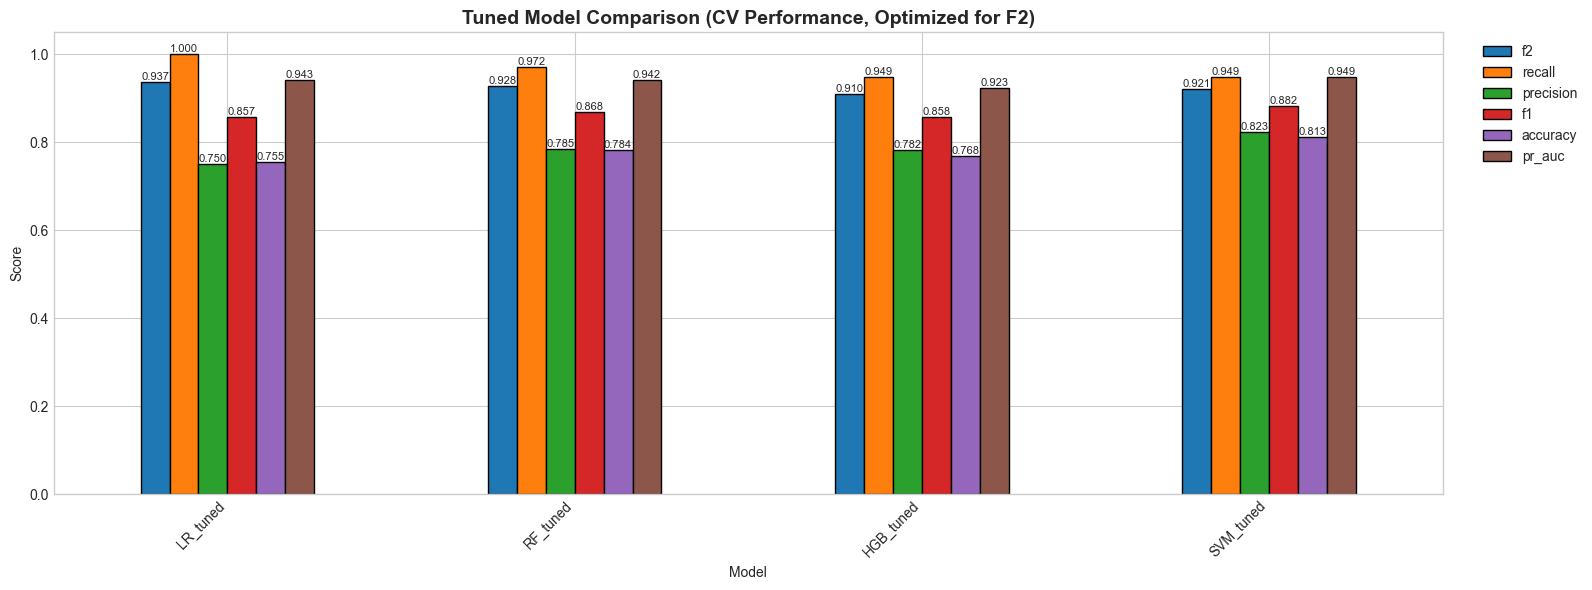

In [26]:
# Compare tuned models
tuned_comparison = compare_models(
    cv_comparison_data,
    metrics_to_display=['f2', 'recall', 'precision', 'f1', 'accuracy', 'pr_auc'],
    title='Tuned Model Comparison (CV Performance, Optimized for F2)',
    save_path='images/ep_tuned_comparison.png'
)

### 4.6 Top Hyperparameter Combinations

Review the top performing hyperparameter combinations for each model to guide future grid adjustments.

In [27]:
# Display top 10 hyperparameter combinations for each model
display_top_hyperparameter_runs(tuned_models, n_top=10, metric='f2')

TOP 10 HYPERPARAMETER COMBINATIONS: LR_tuned
 rank   val_f2  val_f2_std  train_f2          gap    C class_weight penalty solver
    1 0.937404    0.002667  0.938500 1.096094e-03 0.70         None      l2  lbfgs
    2 0.936405    0.001994  0.936729 3.241822e-04 0.60         None      l2  lbfgs
    3 0.935197    0.005840  0.941000 5.802269e-03 0.80         None      l2  lbfgs
    4 0.935077    0.000773  0.936068 9.908581e-04 0.50         None      l2  lbfgs
    5 0.933427    0.000166  0.933428 1.235422e-06 0.40         None      l2  lbfgs
    6 0.932962    0.005338  0.940951 7.989375e-03 0.90         None      l2  lbfgs
    7 0.932769    0.000567  0.932770 5.433045e-07 0.01         None      l2  lbfgs
    7 0.932769    0.000567  0.932770 5.433045e-07 0.10         None      l2  lbfgs
    7 0.932769    0.000567  0.932934 1.649846e-04 0.30         None      l2  lbfgs
    7 0.932769    0.000567  0.932770 5.433045e-07 0.20         None      l2  lbfgs

Best parameters: {'C': 0.7, 'class_weight

## 5. Overfitting Analysis

Analyze the gap between training and validation performance using CV results. This analysis uses only training data (through cross-validation) and does NOT use the held-out test set.

**Key insight**: In GridSearchCV, `mean_train_*` scores are computed on the training folds and `mean_test_*` scores are computed on the validation folds. A large gap indicates overfitting.

### 5.1 Train-Validation Gap Summary

In [28]:
# Get summary of train-validation gaps for all tuned models
gap_summary_df = get_gap_summary(tuned_models, metric='f2')


TRAIN-VALIDATION GAP SUMMARY (F2)

Gap thresholds: Warning >= 5%, Severe >= 10%

--------------------------------------------------------------------------------

✓ LR_tuned:
    Train f2: 0.9385 (+/- 0.0011)
    Val f2:   0.9374 (+/- 0.0027)
    Gap:        0.0011 (0.1%) [Good]

⚠ RF_tuned:
    Train f2: 1.0000 (+/- 0.0000)
    Val f2:   0.9276 (+/- 0.0050)
    Gap:        0.0724 (7.2%) [MODERATE]

⚠ HGB_tuned:
    Train f2: 0.9672 (+/- 0.0011)
    Val f2:   0.9102 (+/- 0.0106)
    Gap:        0.0570 (5.9%) [MODERATE]

✓ SVM_tuned:
    Train f2: 0.9298 (+/- 0.0087)
    Val f2:   0.9209 (+/- 0.0061)
    Gap:        0.0089 (1.0%) [Good]




LR_tuned - Train-Validation Gap Analysis

Metric: f2
  Training score:   0.9385
  Validation score: 0.9374
  Gap:              0.0011 (0.1%)

Diagnosis: Good fit
  (Warning threshold: 5%, Severe threshold: 10%)
  Figure saved: images/ep_lr_tuned_train_val_gap.png


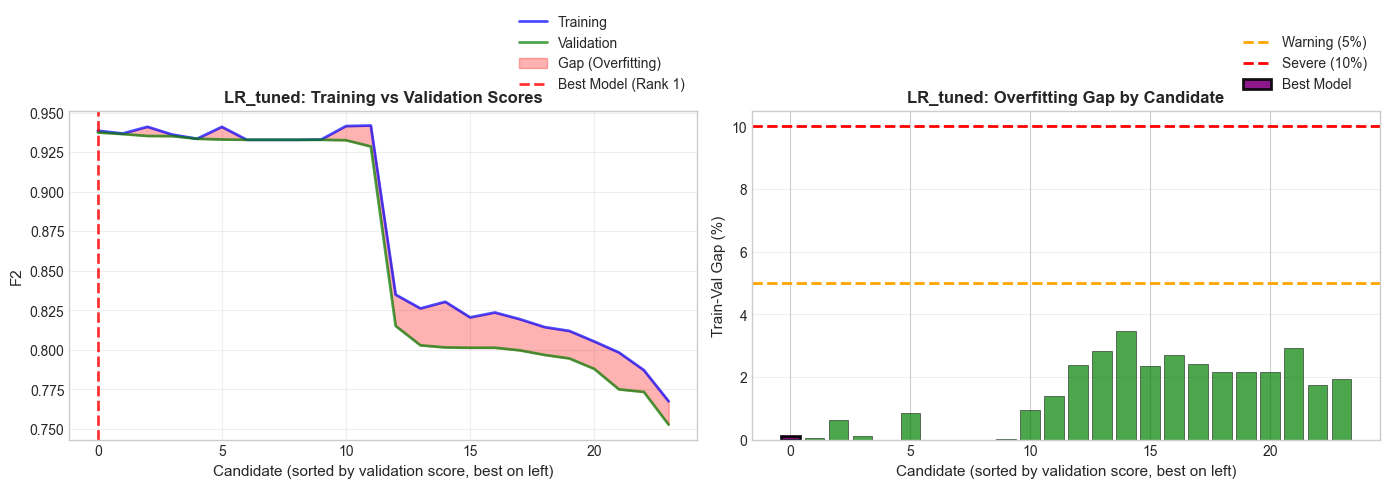

In [29]:
# Detailed train-validation gap analysis for the best model
# Find the best model by CV F2
best_cv_model_name = max(cv_comparison_data, key=lambda x: x['f2'])['model_name']
best_cv_search = tuned_models[best_cv_model_name]

gap_result = analyze_cv_train_val_gap(
    best_cv_search, 
    metric='f2',
    model_name=best_cv_model_name,
    save_path=f'images/ep_{best_cv_model_name.lower()}_train_val_gap.png'
)

### 5.2 Performance vs Complexity Parameter

Analyze how the best model's performance changes with its primary complexity parameter (n_estimators for RF, max_iter for HGB, C for LR/SVM), using optimal values for other parameters from tuning.

In [30]:
# Configuration for iteration analysis by model type
# Maps model name to: (param_name, param_values, estimator_class, fixed_params_to_copy)
iteration_configs = {
    'RF_tuned': {
        'param_name': 'n_estimators',
        'param_values': [30, 40, 50, 60, 70, 80, 100, 120, 150, 200, 250, 300, 350, 400],
        'estimator_class': RandomForestClassifier,
        'fixed_params': ['max_depth', 'min_samples_split', 'min_samples_leaf', 'class_weight'],
        'extra_params': {'random_state': RANDOM_STATE, 'n_jobs': -1},
        'requires_dense': False,
    },
    'HGB_tuned': {
        'param_name': 'max_iter',
        'param_values': [30, 40, 50, 60, 70, 80, 100, 120, 150, 200, 250, 300],
        'estimator_class': HistGradientBoostingClassifier,
        'fixed_params': ['learning_rate', 'max_depth', 'min_samples_leaf', 'l2_regularization', 'class_weight'],
        'extra_params': {'random_state': RANDOM_STATE},
        'requires_dense': True,
    },
    'LR_tuned': {
        'param_name': 'C',
        'param_values': [0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0],
        'estimator_class': LogisticRegression,
        'fixed_params': ['penalty', 'solver', 'class_weight'],
        'extra_params': {'max_iter': 2000, 'random_state': RANDOM_STATE},
        'requires_dense': False,
    },
    'SVM_tuned': {
        'param_name': 'estimator__C',
        'param_values': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0, 1.5, 3.0, 5.0, 10.0],
        'estimator_class': CalibratedClassifierCV,
        'fixed_params': ['estimator__class_weight'],
        'extra_params': {
            'estimator': LinearSVC(max_iter=2000, random_state=RANDOM_STATE),
            'cv': 3
        },
        'requires_dense': False,
    },
}

# Map model names to display names
model_display_names = {
    'LR_tuned': 'Logistic Regression',
    'RF_tuned': 'Random Forest', 
    'HGB_tuned': 'HistGradientBoosting',
    'SVM_tuned': 'Linear SVM',
}

# Get configuration for best model
if best_cv_model_name in iteration_configs:
    config = iteration_configs[best_cv_model_name]
    best_params = best_cv_search.best_params_.copy()
    
    print(f"Analyzing {config['param_name']} performance for {model_display_names[best_cv_model_name]}")
    print(f"Testing values: {config['param_values']}")
    
    # Build param grid with all params fixed except the iteration param
    iteration_param_grid = {config['param_name']: config['param_values']}
    for param in config['fixed_params']:
        if param in best_params:
            iteration_param_grid[param] = [best_params[param]]
    
    # Create and run grid search
    iteration_search = create_search_object(
        search_type='grid',
        estimator=config['estimator_class'](**config['extra_params']),
        param_grid=iteration_param_grid,
        cv=cv,
        refit='f2'
    )
    
    # Use appropriate data format
    X_iteration = X_trainval_hgb if config['requires_dense'] else X_trainval
    
    iteration_search, _, _ = tune_with_logging(
        iteration_search, X_iteration, y_trainval,
        model_name=f'ep_{best_cv_model_name.lower()}_iterations'
    )
else:
    print(f"No iteration analysis configured for {best_cv_model_name}")
    iteration_search = None

Analyzing C performance for Logistic Regression
Testing values: [0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0]

HYPERPARAMETER TUNING: ep_lr_tuned_iterations
Total parameter combinations: 12
Cross-validation folds: 3
Total fits: 36
Log file: models/logs/ep_lr_tuned_iterations_20251225_010634.log

Tuning complete!
Best score (f2): 0.9374
Results saved to: models/logs/ep_lr_tuned_iterations_20251225_010634_cv_results.csv



Logistic Regression - C Performance Analysis

Metric: f2

Optimal C: 0.7
  Training F2:   0.9385
  Validation F2: 0.9374
  Gap:               0.0011 (0.1%)

Tuned C from hyperparameter search: 0.7
  Training F2:   0.9385
  Validation F2: 0.9374
  Gap:               0.0011 (0.1%)
  Figure saved: images/ep_lr_tuned_iteration_performance.png


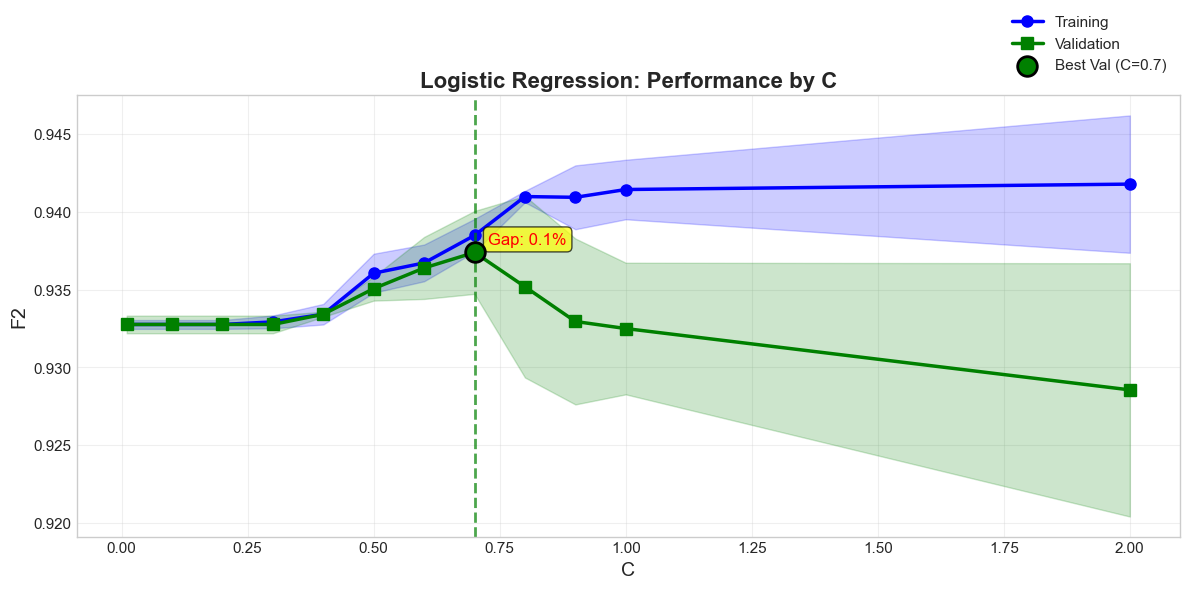

In [31]:
# Analyze performance across parameter values with confidence bands
if iteration_search is not None:
    config = iteration_configs[best_cv_model_name]
    
    # Get the tuned value from main hyperparameter search
    tuned_value = best_cv_search.best_params_.get(config['param_name'])
    
    iteration_result = analyze_iteration_performance(
        iteration_search,
        param_name=config['param_name'],
        metric='f2',
        tuned_value=tuned_value,
        model_name=model_display_names[best_cv_model_name],
        save_path=f'images/ep_{best_cv_model_name.lower()}_iteration_performance.png'
    )
else:
    print("Skipping iteration performance analysis")

## 6. Final Model Selection

In [32]:
# Select best model based on CV F2
best_model_name, best_model_metrics = get_best_model(tuned_comparison, 'f2')
print(f"Selected model: {best_model_name}")
print(f"CV F2: {best_model_metrics['f2']:.4f} (primary metric)")
print(f"CV Recall: {best_model_metrics['recall']:.4f}")
print(f"CV Precision: {best_model_metrics['precision']:.4f}")

# Get the best fitted model
best_search = tuned_models[best_model_name]
best_model = best_search.best_estimator_

# Save best classifier for ep3
classifier_path = MODELS_DIR / 'ep_best_classifier.joblib'
joblib.dump(best_model, classifier_path)
print(f"\nBest classifier saved to: {classifier_path}")


Best model by f2: LR_tuned
Score: 0.9374
Selected model: LR_tuned
CV F2: 0.9374 (primary metric)
CV Recall: 1.0000
CV Precision: 0.7498

Best classifier saved to: /home/fdpearce/Documents/Courses/DataTalksClub/projects/machine-learning-zoomcamp/sportswear-esg-news-classifier/models/ep_best_classifier.joblib


In [33]:
# Save CV metrics for comparison in ep3
cv_metrics = {
    'model_name': best_model_name,
    'cv_f2': float(best_model_metrics['f2']),
    'cv_recall': float(best_model_metrics['recall']),
    'cv_precision': float(best_model_metrics['precision']),
    'cv_f1': float(best_model_metrics['f1']),
    'cv_accuracy': float(best_model_metrics['accuracy']),
    'cv_pr_auc': float(best_model_metrics['pr_auc']),
    'best_params': best_search.best_params_,
    'transformer_method': transformer.method,
    'n_folds': N_FOLDS,
}

cv_metrics_path = MODELS_DIR / 'ep_cv_metrics.json'
with open(cv_metrics_path, 'w') as f:
    json.dump(cv_metrics, f, indent=2)
print(f"CV metrics saved to: {cv_metrics_path}")

CV metrics saved to: /home/fdpearce/Documents/Courses/DataTalksClub/projects/machine-learning-zoomcamp/sportswear-esg-news-classifier/models/ep_cv_metrics.json


In [34]:
print("=" * 60)
print("EP2 NOTEBOOK SUMMARY")
print("=" * 60)
print(f"\nBest Model: {best_model_name}")
print(f"Feature Method: {transformer.method}")
print(f"\nCV Performance ({N_FOLDS}-fold):")
print(f"  F2 Score:  {best_model_metrics['f2']:.4f}")
print(f"  Recall:    {best_model_metrics['recall']:.4f}")
print(f"  Precision: {best_model_metrics['precision']:.4f}")
print(f"\nBest Hyperparameters:")
for param, value in best_search.best_params_.items():
    print(f"  {param}: {value}")
print(f"\nSaved Artifacts for ep3:")
print(f"  - {classifier_path}")
print(f"  - {cv_metrics_path}")
print(f"\nNext: Run ep3_model_evaluation_deployment.ipynb for:")
print(f"  - Final test set evaluation")
print(f"  - Threshold optimization")
print(f"  - Pipeline export for deployment")
print("=" * 60)

EP2 NOTEBOOK SUMMARY

Best Model: LR_tuned
Feature Method: tfidf_lsa

CV Performance (3-fold):
  F2 Score:  0.9374
  Recall:    1.0000
  Precision: 0.7498

Best Hyperparameters:
  C: 0.7
  class_weight: None
  penalty: l2
  solver: lbfgs

Saved Artifacts for ep3:
  - /home/fdpearce/Documents/Courses/DataTalksClub/projects/machine-learning-zoomcamp/sportswear-esg-news-classifier/models/ep_best_classifier.joblib
  - /home/fdpearce/Documents/Courses/DataTalksClub/projects/machine-learning-zoomcamp/sportswear-esg-news-classifier/models/ep_cv_metrics.json

Next: Run ep3_model_evaluation_deployment.ipynb for:
  - Final test set evaluation
  - Threshold optimization
  - Pipeline export for deployment
